In [1]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
twitter = pd.read_csv('sentiment.tsv', sep="\t",names=['Label','Tweet'])

In [4]:
twitter.head()

,Label,Tweet
0,neg,"@jamielewislewis i cant believe it, it really ..."
1,pos,having a vodka tonic and looking forward to go...
2,pos,@ddlovatofans1neg1 Could you follow me please....
3,pos,@jordanknight for once.................. PLEAS...
4,neg,Had a dream about a walk in fast food resturau...


In [5]:
import string
from nltk.corpus import stopwords

In [6]:
# Make A List of Words That Has To Be Removed 
stopset = set(stopwords.words('english')) - set(('over', 'under', 'below', 'more', 'most', 'no', 'not', 'only', 'such', 'few', 'so', 'too', 'very', 'just', 'any', 'once'))

In [7]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [8]:
tknz = TweetTokenizer()
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [9]:
# Function To Clean Tweet Of Unwanted Words

def tweet_clean_process(tweet):
        
    # Remove Username and Http Links Present In Tweet
    tweet = ' '.join([word.lower() for word in tweet.split() if 'http' not in word and not word.startswith('@')])
    
    # Tweet Tokenize the Text
    tweet = ' '.join([word.lower() for word in tknz.tokenize(tweet)])
                 
    # Remove Punctations Present In Tweet
    tweet = ''.join([char for char in tweet if char not in string.punctuation])
            
    # Lemmatize Tweet
    tweet = ' '.join([lemmatizer.lemmatize(word) for word in tweet.split() ])
   
    # Stem Tweet
    # tweet = ' '.join([stemmer.stem(word) for word in tweet.split() ])
   
    # Remove Stop Words Present In Tweet
    tweet = ' '.join([word for word in tweet.split() if word not in stopset])

    # Return Clean Tweet
    return tweet

In [10]:
# Clean Tweets and Find Length of Each Tweet
twitter['Tweet'] = twitter['Tweet'].apply(tweet_clean_process)
twitter['Length'] = twitter['Tweet'].apply(len)

In [11]:
# Function To Classify Tweets Based On Its Compound Polarity Score
def tweet_score_conversion(score):    
    if score < 0:
        return "negative"
    elif score < 0.35:
        return "neutral"
    else:
        return "positive"

In [12]:
# Initialize Sentiment Analyzer To Find Polarity Of Tweet [Negative, Neutral, Postive]
senti_analyzer = SentimentIntensityAnalyzer()
tweet_score = [senti_analyzer.polarity_scores(i)['compound'] for i in twitter['Tweet'] ]

In [13]:
# Classify Tweet Based on Polarity Scores of Tweet
tweet_results = [tweet_score_conversion(x) for x in tweet_score]

In [14]:
# Add Columns To Existing Data Frame Representing It's Compound Score And Sentiment
twitter['Compound Score'] = pd.DataFrame(tweet_score)
twitter['Sentiment'] = pd.DataFrame(tweet_results)

In [15]:
twitter.head()

,Label,Tweet,Length,Compound Score,Sentiment
0,neg,cant believe really doesnt belong hope doesnt ...,92,0.2135,neutral
1,pos,vodka tonic looking forward going saddle ranch...,75,0.0000,neutral
2,pos,could follow please would really appreciate,43,0.6478,positive
3,pos,once please tell u u thinking person,36,0.3182,neutral
4,neg,dream walk fast food resturaunt sold ice cream...,78,0.2500,neutral


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015C613EEB00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000015C615EB400>]], dtype=object)

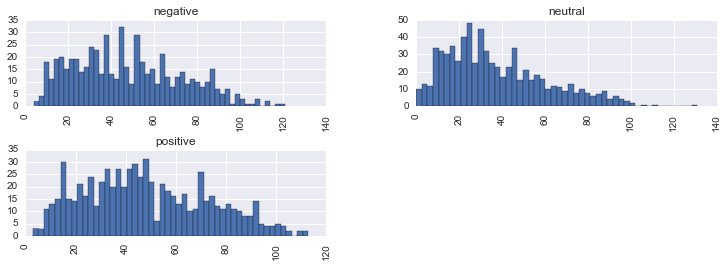

In [16]:
# Display Length Of Tweets Based On It's Sentiment
twitter.hist(column='Length', by='Sentiment', bins=50,figsize=(12,4))

### Achieve 0.803+ AUC Using 10 Fold Cross-Validation

In [17]:
from sklearn.pipeline import Pipeline

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

In [20]:
# Initialize Input Features and Output Label
X = twitter['Tweet']
y = twitter['Sentiment']

In [21]:
# Initialize 10 Fold Cross-Validation Data Set
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=None)

In [22]:
# Initialize Pipeline 
### Initialize CountVectorizer To N-Gram Bag Of Words Consisiting of Different Combination of 1-5 characters
### Initialize TfidfTransformer To Convert Integer Counts To Weighted TF-IDF scores
### Initialize OneVsRestClassifier To Perform Text Classification Using LogisticRegression

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer='char_wb', ngram_range=(1,5), min_df = 1, max_features=25000)), 
    ('tfidf', TfidfTransformer(smooth_idf=True,sublinear_tf=True, use_idf=True)),  # integer counts to weighted TF-IDF scores
    ('classifier', OneVsRestClassifier(LogisticRegression(solver='liblinear', dual=False, max_iter=50000, C=2, \
                fit_intercept=True, warm_start=True, tol=1e-5,multi_class='ovr' ))), 
]) 


In [23]:
# Compute K-Fold Cross Validation Using Pipeline Initialized 
results_predict = cross_val_predict(pipeline, X, y, cv=kfold, method='predict_proba')

In [24]:
# 1 Hot Encoding Of Sentiment Column
y = label_binarize(twitter['Sentiment'], classes=['negative','neutral','positive'])

In [25]:
# Reference To Compute ROC Curve and Area For Each Class
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

fpr = dict()
tpr = dict()

n_classes = 3
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], results_predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

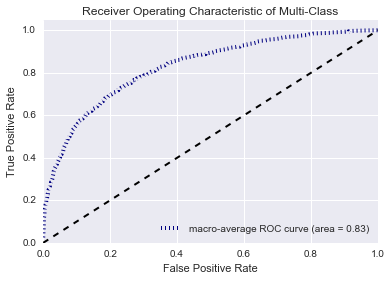

In [26]:
# Reference To Plot ROC Curve and Area
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from scipy import interp
from itertools import cycle

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate All ROC Curves 
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Compute Average
mean_tpr /= n_classes

# Compute AUC
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC Curve
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Multi-Class')
plt.legend(loc="lower right")
plt.show()

In [27]:
# Display Area Under Curve
print ("ROC_AUC is {0:.3f} ".format(roc_auc["macro"]))

ROC_AUC is 0.827 
